In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cupy as cp

In [2]:
import sys
sys.path.append('..')
import projector.ct_projector_cupy as ct_projector

In [3]:
# load a sample CT image
img = np.load('./CTA0296_7_2.npy')
spacing = [1, 1, 1]
img = img[np.newaxis, ...]

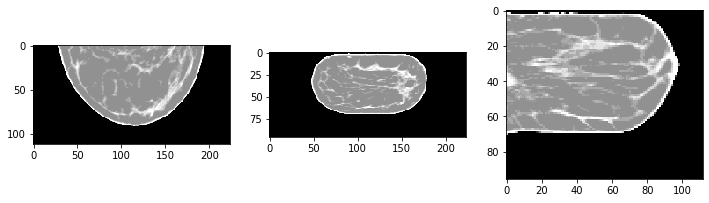

In [4]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [5]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./tomo.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = img.shape[1]
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.cx = 0
projector.cy = img.shape[2] * spacing[2] / 2
projector.cz = 11

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 9
nu = 256
nv = 256
nx = 224
ny = 112
nz = 96
dx = 1
dy = 1
dz = 1
cx = 0
cy = 56.0
cz = 11
dsd = 660.0
dso = 618.0
du = 1.0
dv = 1.0
off_u = 0
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f38b5611dd0>


In [6]:
# setup the positions of projections, let's do 0, 45, 90, and 135
angles = np.arange(-12, 13, 3) * np.pi / 180

srcs = np.array([projector.dso * np.sin(angles),
                 [0] * len(angles), 
                 projector.dso * np.cos(angles)]).T

det_centers = np.array([[0] * len(angles),
                        [projector.nv * projector.dv / 2] * len(angles), 
                        [projector.dso - projector.dsd] * len(angles)]).T

det_us = np.array([1, 0, 0] * len(angles)).T
det_vs = np.array([0, 1, 0] * len(angles)).T

In [7]:
# very important: use np.copy('C') so that the arrays are saved in C order
cp.cuda.Device(0).use()

cuimg = cp.array(img, cp.float32, order = 'C')
cusrcs = cp.array(srcs, cp.float32, order = 'C')
cudet_centers = cp.array(det_centers, cp.float32, order = 'C')

In [9]:
projector.set_projector(projector.distance_driven_fp_tomo, det_center = cudet_centers, src = cusrcs)
projector.set_backprojector(projector.distance_driven_bp_tomo, det_center = cudet_centers, src = cusrcs)

In [10]:
# set which device to use
# forward projection
cufp = projector.fp(cuimg)
# fp = projector.siddon_cone_fp_abitrary(img, det_centers, det_us, det_vs, srcs)

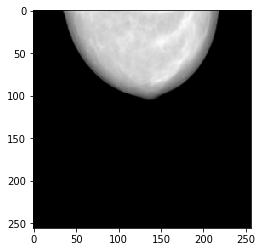

In [11]:
fp = cufp.get()
plt.imshow(fp[0,4,...], 'gray')

In [12]:
cubp = projector.bp(cufp)

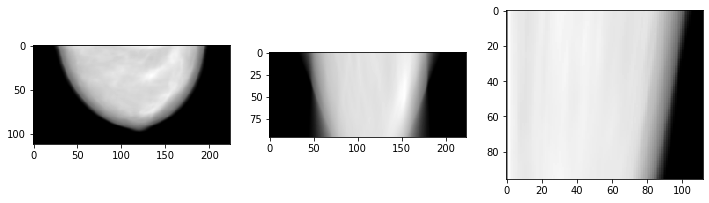

In [13]:
bp = cubp.get()
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(bp[0, bp.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(bp[0, :, bp.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(bp[0, ..., bp.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])